# Finding discords of any length in a time series

This tutorial explains the MERLIN algorithm proposed in [MERLIN](https://www.cs.ucr.edu/~eamonn/MERLIN_Long_version_for_website.pdf). 

You can find the support webpage here: [MERLIN: SUPPORT](https://sites.google.com/view/merlin-find-anomalies).

The algorithm provides the discords of arbitrary length in time series.

## import libraries

In [149]:
%matplotlib inline

import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
import math

plt.style.use('stumpy.mplstyle')

## import toy data set: noisy sine wave

In [150]:
from scipy.io import loadmat

# data set is available at: 
# https://drive.google.com/file/d/1cDkZVKYse_E0_fGZqTRQZrrMBRFrR2Mv/view

data = loadmat("MERLIN_datasets\\NoisySine.mat") 
ts = data['T'].reshape(-1,)

## Visualizing data

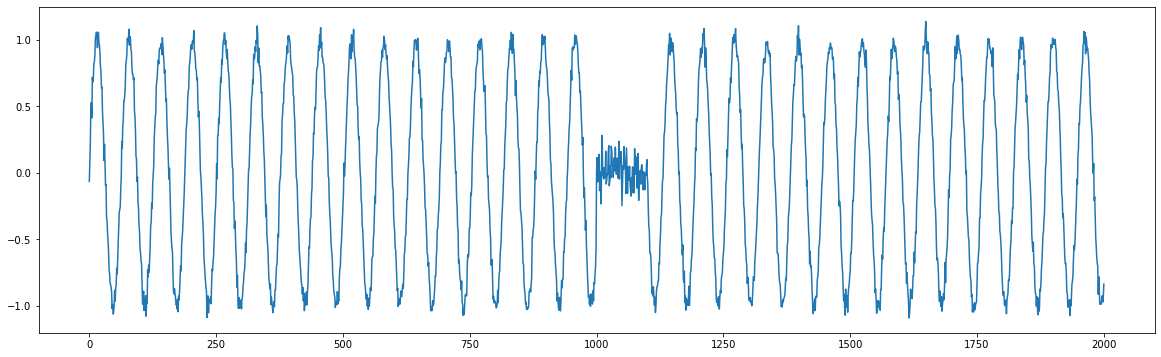

In [151]:
plt.plot(ts)
plt.show()

As depicted in the figure above, there is an anomaly in the sequence

## implemeting MERLIN algorithm (In contrast to paper, we consider STUMPY exclusion to compare the results with MP)

### part I: DRAG algorithm 

DRAG algorithm is a name used by the authors to refer to the algorithm proposed in [](). The DRAG aglorithm tries to find a set of discords for a user-defined r (range of discord: the threshold. A subsequence is discord if its distance to its NN is not less than r.

In [152]:
def candidate_selection_algorithm(
    T, 
    m, 
    r,
    sep = None
):
    """
    For a time series T, the algorithm finds a set of discords whose distance with their NN is more than r. 
    
    Parameters
    ---------
    T: ndarray
        the time series for which we try to find the discords
    
    m: int
        the length of the subsequence to consider in discovering the discords
    
    r: float
        the maximum distance allowed for non-discord subsquence to its NN subsequence 
        (threshold for discords' distance)
    
    
    output
    --------
    C: set
        a set of discords
    
    """
    z_normalize = True
    
    #create empty set
    C = set()
    
    if sep is None:
        sep = math.ceil(m/4) + 1
    
    
    
    #scan all subsequences
    for i in range(0,len(T)-m):
        is_candidate = True
        T_i = T[i:(i+m)]
        T_i = stumpy.core.z_norm(T_i)
        
        for j in C:
            if abs(i-j)>=sep: #non-trival match test
                T_j = T[j:(j+m)]
                T_j = stumpy.core.z_norm(T_j)
                
                dist = np.linalg.norm(T_i-T_j)
                if dist < r:
                    is_candidate = False
                    break
        
        if is_candidate:
            C.add(i)
        else:
            C.remove(j)

            
    return C

In [153]:
T = ts[:]
m = 512 #one day as the length of subsequence
r = 10.27

C = candidate_selection_algorithm(T, m, r)
print('set C is: \n', C)

set C is: 
 {584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 735, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 771, 780, 781, 792, 793, 794, 795, 796, 797, 798, 799, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 824, 825, 826, 827, 828, 829, 830, 831, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 864, 865, 885, 886, 887, 896, 906, 907, 908, 909, 91

In [154]:
def discords_refinement_algorithm(
    T, 
    m, 
    r, 
    C,
    sep=None
):
    """
    For a time series T, the algorithm refines a set of discords by removing the false positives,
    i.e. the subsequences whose distance from their NN is more than r. 
    
    Parameters
    ---------
    T: ndarray
        the time series for which we try to find the discords
    
    m: int
        the length of the subsequence to consider in discovering the discords
    
    r: float
        the maximum distance allowed for non-discord subsquence to its NN subsequence 
        (threshold for discords' distance)
    
    C: set
        the set of indices of initially-discovered discored
    
    
    output
    --------
    discords: dataframe
        a dataframe where each row corresponds to a discovered discord 
        The columns are: ['Discord index', 'Discord NN index', 'NN distance']
        
    """
    
    if sep is None:
        sep = math.ceil(m/4) + 1
        
    C_list = list(C)
    
    D=np.empty(shape=(len(C_list),3)) #[discord index, discord NN index, NN dist]
    D[:,0] = C_list
    D[:,1] = -1
    D[:,2] = float('inf')
    
    _to_be_removed_idx = []
    
    
    for i in range(0, len(T)-m):
        if len(C_list)==0:
            print('The set C is empty. No discord discovered!')
            break
        
        is_discord = True
        T_i = stumpy.core.z_norm(T[i:(i+m)])
        
        for j_idx, j in enumerate(C_list):
            if j_idx not in _to_be_removed_idx:
                if abs(i-j)>=sep:
                    T_j = stumpy.core.z_norm(T[j:(j+m)])

                    dist = np.linalg.norm(T_i-T_j)
                    if dist<r:
                        _to_be_removed_idx.append(j_idx)
                    else:
                        if dist<D[j_idx,2]:
                            D[j_idx,2] = dist
                            D[j_idx,1] = i
    
    D_pruned = np.delete(D, _to_be_removed_idx, axis=0)
    discords = pd.DataFrame(data = D_pruned, 
                  columns = ['Discord index', 'Discord NN index', 'NN distance'])
        
    return discords

In [155]:
discords = discords_refinement_algorithm(T, m, r, C)
discords

,Discord index,Discord NN index,NN distance
0,592.0,152.0,10.270556
1,593.0,153.0,10.274022
2,594.0,154.0,10.273065
3,621.0,181.0,10.270276
4,622.0,182.0,10.278849
5,623.0,183.0,10.284921
6,624.0,184.0,10.285366
7,625.0,185.0,10.285081
8,626.0,186.0,10.279453
9,627.0,187.0,10.272296


In [156]:
discords_sorted = discords.sort_values(by ='NN distance', ascending=False, ignore_index=True)
discords_sorted

,Discord index,Discord NN index,NN distance
0,718.0,278.0,10.301397
1,719.0,1096.0,10.301242
2,687.0,247.0,10.297374
3,686.0,246.0,10.297224
4,688.0,248.0,10.295380
5,717.0,277.0,10.295350
6,655.0,215.0,10.294041
7,656.0,216.0,10.291022
8,654.0,214.0,10.290871
9,685.0,245.0,10.289942


#### PLOT the Top Discord

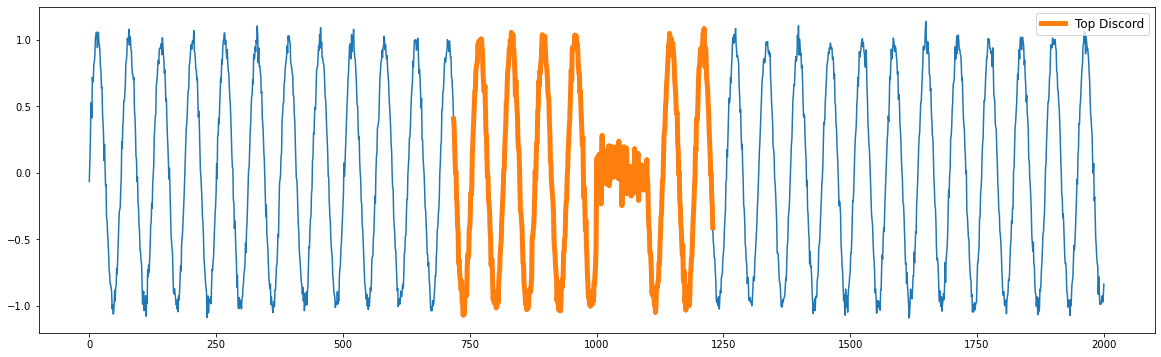

In [157]:
Top_Discord = discords_sorted.iloc[0,:]
Top_Discord_idx = int(Top_Discord[0])

plt.plot(ts)
plt.plot(np.arange(Top_Discord_idx,Top_Discord_idx+m),ts[Top_Discord_idx:Top_Discord_idx+m], lw=5, label='Top Discord')
plt.legend(fontsize=12)
plt.show()

In [158]:
#reproduce result of paper
discords_idx_sorted = discords.sort_values(by ='Discord index', ascending=True)
discords_idx_sorted

,Discord index,Discord NN index,NN distance
0,592.0,152.0,10.270556
1,593.0,153.0,10.274022
2,594.0,154.0,10.273065
3,621.0,181.0,10.270276
4,622.0,182.0,10.278849
5,623.0,183.0,10.284921
6,624.0,184.0,10.285366
7,625.0,185.0,10.285081
8,626.0,186.0,10.279453
9,627.0,187.0,10.272296


### DRAG algorithm:

Let's combine the first two algorithm to only return the first discorc

In [159]:
def DRAG(T,m,r, separation_fraction=None):
    """
    For a time series T, the algorithm finds a set of discords whose distance with their NN is more than r. 
    
    Parameters
    ---------
    T: ndarray
        the time series for which we try to find the discords
    
    m: int
        the length of the subsequence to consider in discovering the discords
    
    r: float
        the maximum distance allowed for non-discord subsquence to its NN subsequence 
        (threshold for discords' distance)
    
    
    output
    --------
    idx: index of top discord
    idx_NN: index of NN of top discord
    dist: dist between top discor and its NN  
    """
    
    #initializing output
    idx = -1; idx_NN = -1; dist = -1
    
    if separation_fraction is None:
        separation_fraction = 1/4
    
    sep = math.ceil(m*separation_fraction) + 1
    
    C = candidate_selection_algorithm(T, m, r, sep) 
    
    if len(C)>0:
        discords = discords_refinement_algorithm(T, m, r, C, sep)
        
        if len(discords['NN distance'])>0:
            top_discord = discords['NN distance'].argmax()
            idx = int(discords.iloc[top_discord, 0])
            idx_NN = int(discords.iloc[top_discord, 1])
            dist = discords.iloc[top_discord, 2] 

    return idx, idx_NN, dist

In [160]:
TopDiscord_idx, TopDiscord_idx_NN, TopDiscord_dist = DRAG(T,m,r) 

print("TopDiscord_idx: ", TopDiscord_idx)
print("TopDiscord_idx_NN: ", TopDiscord_idx_NN)
print("TopDiscord_dist: ", TopDiscord_dist)

TopDiscord_idx:  718
TopDiscord_idx_NN:  278
TopDiscord_dist:  10.301397123539063


In [161]:
#let's use STUMPY matrix profile:
mp = stumpy.stump(T, m)
discord_idx_MP = np.argmax(mp[:,0])
discord_NN_idx_MP = mp[discord_idx_MP,1]
discord_dist_MP = mp[discord_idx_MP,0]

print("discord_idx via matix profile: ", discord_idx_MP)
print("discord_NN_idx via matix profile: ", discord_NN_idx_MP)
print("discord_dist via matix profile: ", discord_dist_MP)

discord_idx via matix profile:  718
discord_NN_idx via matix profile:  278
discord_dist via matix profile:  10.30139712353895


### part II: MERLIN algorithm 

After the implementation of DRAG algorithm, we are at the position where we can start to implement MERLIN algorithm:

In [163]:
def MERLIN(T, MinL, MaxL, separation_fraction=None):
    """
    For a time series T, the algorithm finds discords with length between MinL and MaxL. 
    
    Parameters
    ---------
    T: ndarray
        the time series for which we try to find the discords
    
    MinL: int
        subsequence length lower bound
    
    MaxL: int
        subsequence length upper bound
    
    separation_fraction: to exclude indices; If None, set it to 1/4 of subsequence length 
    
    output
    --------
    Discords : ndarray
        a two dimentional array where the axis 0 contains different discords and axis 1 has the information 
        of discord: 
        first column is the starting index of the discord subsequence
        second column is the length of the discord
        third column is the NN index
        fourth column is the distance of the discord to its NN
    
    """
    Discords = np.empty(shape = (0, 4), dtype='object') #Alternatively: Create np array with nrows=MaxL-MinL+1
    
    
    # Calculate the first discord of length MinL
    print('Stage#1: Calculating the first discord...')
    m = MinL
    r = 2 * (m ** 0.5)
    dist = -1
    while dist < 0:
        idx, idx_NN, dist = DRAG(T, m, r, separation_fraction)
        r = r / 2
    
    new_discord = [idx, m, idx_NN, dist]
    Discords = np.vstack((Discords, new_discord))
    print('Discords after finding the first one: \n', new_discord)
    
    
    # Calculate next four discords (for the next four subsequent length)
    print('Stage#2: Calculating the next four discords...')
    dist_old = dist # we need the dist of the previous discord to modify r
    for m in range(MinL+1,MinL+5): 
        r = 0.99 * dist_old 
        
        dist = -1
        while dist < 0:
            idx, idx_NN, dist = DRAG(T, m, r, separation_fraction)
            r = 0.99 * r
            
        new_discord = [idx, m, idx_NN, dist]
        Discords = np.vstack((Discords, new_discord))
        dist_old = dist
        print('>>> Discords after finding the next four discords: ', new_discord)
    
    
    # Calculate the remaining discords
    print('Stage#3: Calculating the remaining discords...')
    for m in range(MinL+5,MaxL+1): #what if MinL+5 > MaxL+1 ? (we need to consider such scenarios)
        mu_dist = np.mean(Discords[-5:, 3]) # calculating the mean of distance of the last 5 discovered discords 
        std_dist = np.std(Discords[-5:, 3]) # calculating the std of distance of the last 5 discovered discords
        
        r = mu_dist - 2 * std_dist
        
        dist = -1
        while dist < 0:
            idx, idx_NN, dist = DRAG(T, m, r, separation_fraction)
            r = r - std_dist
        
        new_discord = [idx, m, idx_NN, dist]
        Discords = np.vstack((Discords, new_discord))
        print('>>> new discord: ', new_discord)
    
    
    return Discords

## Let's use MERLIN on TAXI data (Fig. 11)

In [164]:
#read data
df_taxi = pd.read_csv("MERLIN_datasets\\NAB_NYC_TAXI\\data\\realKnownCause\\nyc_taxi.csv") 
df_taxi = df_taxi.set_index(['timestamp'])

#select the range of dates considered in the paper
data =  df_taxi.loc['2014-10-01 00:00:00' : '2014-12-15 23:00:00']
data

,value
timestamp,
2014-10-01 00:00:00,12751
2014-10-01 00:30:00,8767
2014-10-01 01:00:00,7005
2014-10-01 01:30:00,5257
2014-10-01 02:00:00,4189
...,...
2014-12-15 21:00:00,21393
2014-12-15 21:30:00,21577
2014-12-15 22:00:00,21019


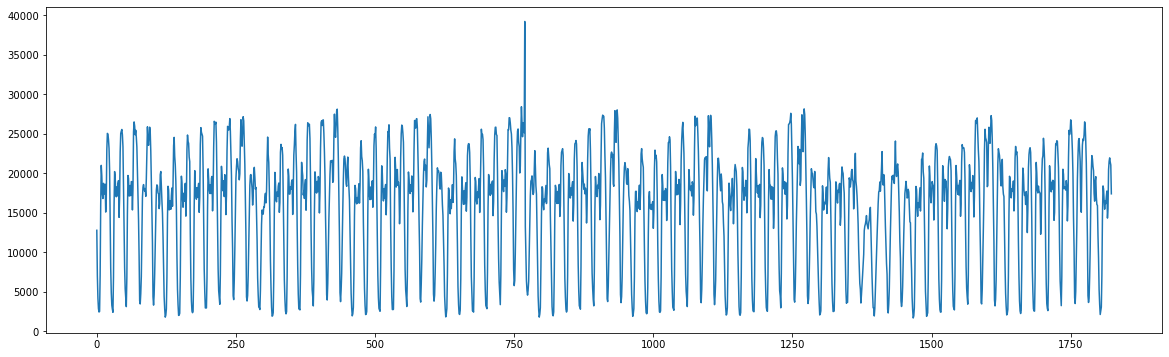

In [165]:
ts = np.reshape(data.to_numpy(),newshape=(-1,))
#let's consider only the data at each hour (not the half hours)
ts = [val for i,val in enumerate(ts) if i % 2 == 0]
ts = np.asarray(ts)

#to use it later in  MATLAB 
np.savetxt("taxi_to_reproduce_paper.csv.csv", ts, delimiter=",")

#plottting
plt.plot(ts)
plt.show()

In [ ]:
np.set_printoptions(suppress=True)
Discords = MERLIN(ts, 5, 96)

In [20]:
#printing Discords:
Discords

array([[1690.0, 5.0, 1120.0, 1.3642079150627304],
       [1522.0, 6.0, 1100.0, 1.4064712539239808],
       [537.0, 7.0, 1689.0, 1.62928107746437],
       [1380.0, 8.0, 443.0, 1.746810126819628],
       [762.0, 9.0, 1328.0, 2.0634858945465493],
       [761.0, 10.0, 1327.0, 2.1247537919540944],
       [760.0, 11.0, 1381.0, 2.629462897528745],
       [759.0, 12.0, 1380.0, 2.746225055671875],
       [758.0, 13.0, 1379.0, 2.9819137944892202],
       [757.0, 14.0, 1261.0, 3.5977491081910626],
       [756.0, 15.0, 1260.0, 3.7262163688495025],
       [755.0, 16.0, 1259.0, 3.8542112273477858],
       [754.0, 17.0, 1258.0, 3.773480491623614],
       [753.0, 18.0, 1257.0, 3.4080630531206326],
       [753.0, 19.0, 1593.0, 3.173663379789231],
       [752.0, 20.0, 1592.0, 2.8985780733789492],
       [752.0, 21.0, 1592.0, 2.670509417879137],
       [769.0, 22.0, 97.0, 2.513778263195744],
       [769.0, 23.0, 97.0, 2.566742363683388],
       [769.0, 24.0, 97.0, 2.5845448370266633],
       [768.0, 25.0

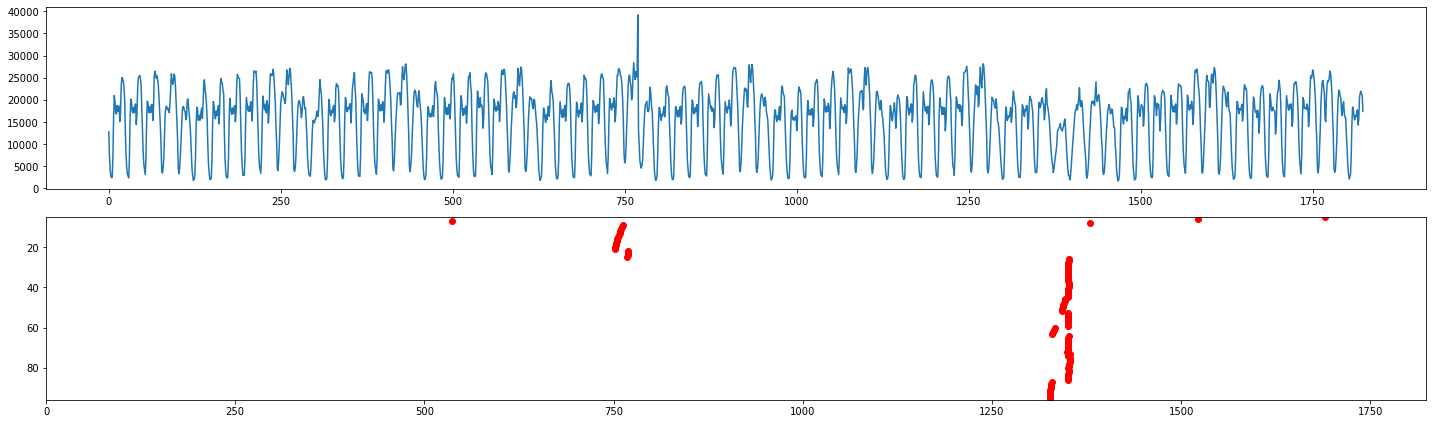

In [20]:
n_ts = len(ts)

fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(ts)

ax[1].set_xlim(left=0, right=n_ts-1) 
ax[1].set_ylim(bottom=96, top=5) 
for item in Discords:
    ax[1].scatter(x=int(item[0]), y=int(item[1]),c='r')

fig.tight_layout()
plt.show()

There are a few discords that is not "clearly" illustrated in the figure 11 of the paper. However, if we zoom in, we will notice that these points are shown (but with lower color value.) These points might be false positives as discussed by paper in some sections.

### Comparing with MATLAB (by the author)

The figure obtained by MATLAB code shown below. Some points are highlighted. These are the ones that are vaguely illustrated in Fig. 11.

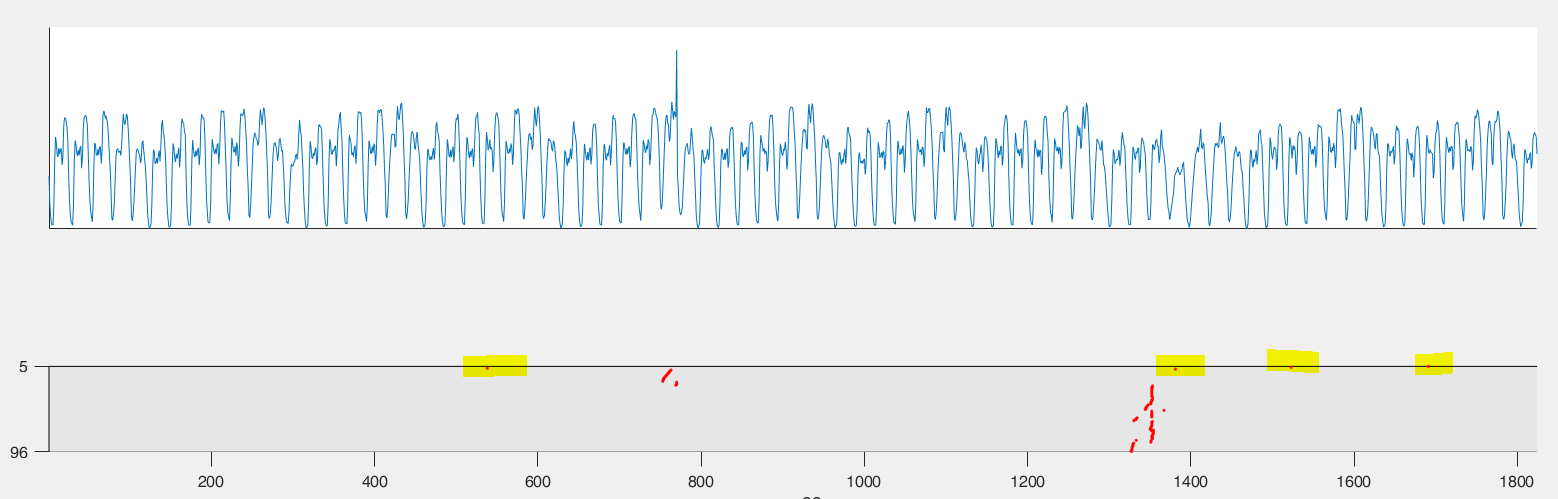



### Comparing values obainted by Python / MATLAB

In [27]:
#two files: Taxi_MATLAB_results.csv (MERLIN3), Taxi_MATLAB_results_r99percent.csv (MERLIN3 but with r=r*0.99)
Discords_by_MATLAB = pd.read_csv("MERLIN_datasets\\taxi_results_by_MATLAB\\Taxi_MATLAB_results.csv", header=None).to_numpy()


for col in range(4):
    modification_val = 0
    if ((col==0) or (col==2)):
        modification_val = 1
    
    Discords_MATLAB = Discords_by_MATLAB[:,col] #by MATLAB code
    Discords_Python = Discords[:,col] + modification_val #by Python code (but with MATLAB indexing)
    
    diff = np.abs(Discords_MATLAB - Discords_Python)
    print(f'> differece at col={col} is: \n {diff}')

> differece at col=0 is: 
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 24.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 19.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0]
> differece at col=1 is: 
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0]
> differece at col=2 is: 
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 

### plot discords that are different in MATLAB and Python

mask:  [47 79]
> Discords_by_MATLAB_only: 
 [[1367.           52.          286.            3.68959178]
 [1333.           84.          948.            5.55797485]]
>  Discords_by_Python_only: 
 [[1342.0 52.0 240.0 4.290034033714779]
 [1351.0 84.0 1519.0 5.963234981527579]]


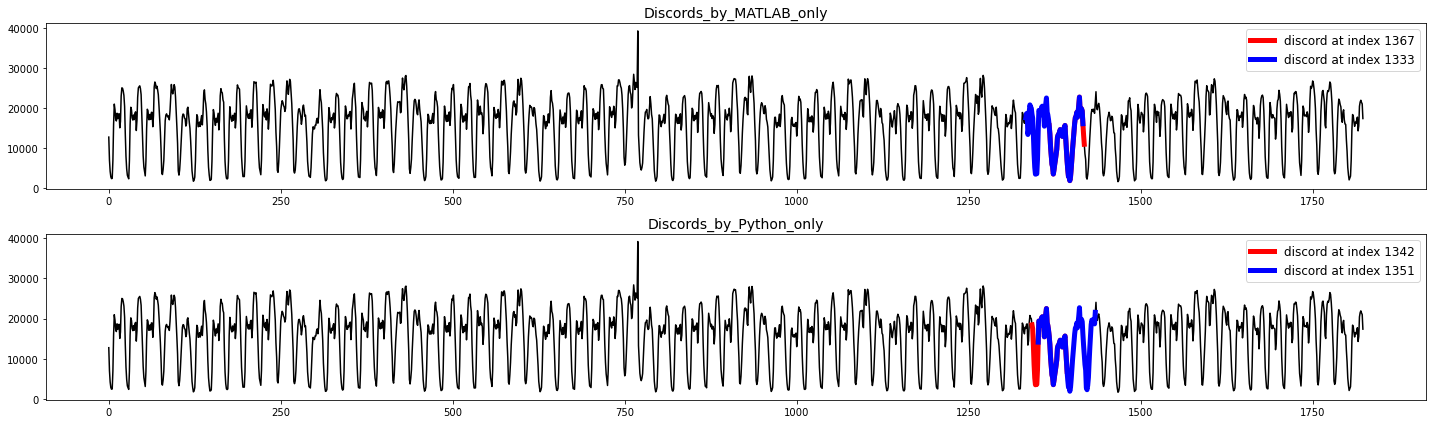

In [28]:
#finding discords that discovered by only Python (Table 3) or by only MATLAB (merlin3.m)
Discords_MATLAB = Discords_by_MATLAB[:,0] #by MATLAB code
Discords_Python = Discords[:,0] + 1 #by Python code (but with MATLAB indexing)

diff = Discords_MATLAB - Discords_Python
mask = np.where(diff != 0)[0]
print('mask: ', mask)

Discords_by_MATLAB_only = Discords_by_MATLAB[np.ix_(mask,)]
print("> Discords_by_MATLAB_only: \n", Discords_by_MATLAB_only)

Discords_by_Python_only = Discords[np.ix_(mask,)]
print(">  Discords_by_Python_only: \n", Discords_by_Python_only)

print('=======================================================================')

#plotting
n_discord = len(Discords_by_Python_only) #= len(Discords_by_MATLAB_only) = len(Discords_by_Python_only)

fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(ts, 'k')
ax[1].plot(ts , 'k')

color_vec = ['r','b','g','cyan']
for n in range(n_discord):
    idx = int(Discords_by_MATLAB_only[n][0])               
    m = int(Discords_by_MATLAB_only[n][1])
    ax[0].plot(np.arange(idx,idx+m), ts[idx:idx+m],c=color_vec[n], lw=5, label=f"discord at index {idx}")
    
    idx = int(Discords_by_Python_only[n][0])
    m = int(Discords_by_Python_only[n][1])
    ax[1].plot(np.arange(idx,idx+m), ts[idx:idx+m],c=color_vec[n], lw=5, label=f"discord at index {idx}")


ax[0].set_title("Discords_by_MATLAB_only",fontsize=14)
ax[1].set_title("Discords_by_Python_only",fontsize=14)

ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)

fig.tight_layout()
plt.show()

## Let's use MERLIN on Mars Science Laboratory data (Fig. 17)

### Fig 17 (Top)

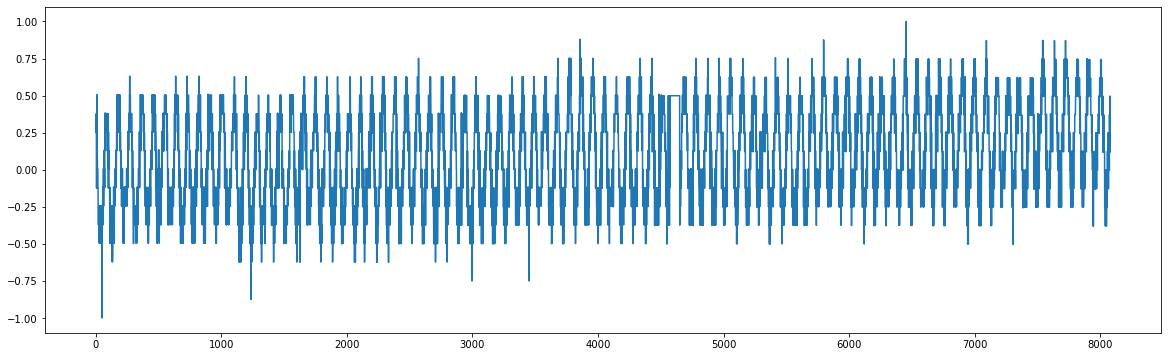

Stage#1: Calculating the first discord...
Discords after finding the first one: 
 [4621, 100, 1856, 10.157679320604531]
Stage#2: Calculating the next four discords...
>>> Discords after finding the next four discords:  [4620, 101, 1855, 10.171769398019203]
>>> Discords after finding the next four discords:  [4619, 102, 1854, 10.193542903240862]
>>> Discords after finding the next four discords:  [4618, 103, 1853, 10.208707651428835]
>>> Discords after finding the next four discords:  [4617, 104, 1852, 10.224377236546244]
Stage#3: Calculating the remaining discords...
>>> new discord:  [4616, 105, 1851, 10.242503500622734]
>>> new discord:  [4615, 106, 1850, 10.260924151058221]
>>> new discord:  [4614, 107, 1849, 10.285198260566528]
>>> new discord:  [4613, 108, 1848, 10.302661801716697]
>>> new discord:  [4612, 109, 1847, 10.322350769548644]
>>> new discord:  [4611, 110, 1846, 10.340590227889743]
>>> new discord:  [4610, 111, 1845, 10.359155157249335]
>>> new discord:  [4609, 112, 1844

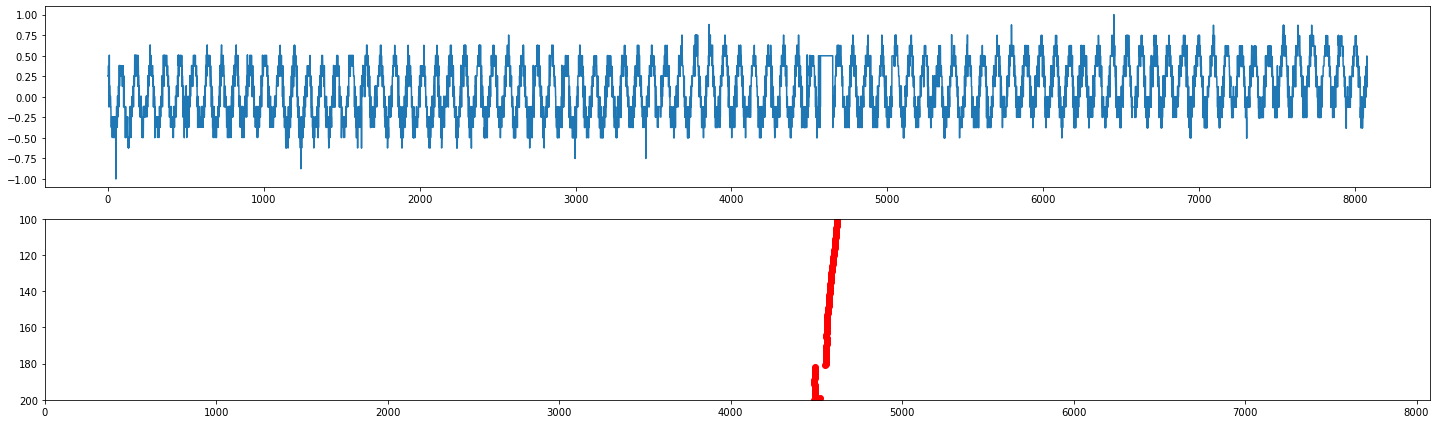

In [14]:
df_MSL_topFigure = pd.read_csv("MERLIN_datasets\\Mars Science Laboratory\\A-4.csv", header=None) 
ts = np.reshape(df_MSL_topFigure.to_numpy(), newshape = (-1, ))

#plot data
plt.plot(ts)
plt.show()

#finging discords of different length
MinL = 100; MaxL = 200;
Discords = MERLIN(ts, MinL, MaxL)
print('----------------------------')
print('Discords are: ', Discords)
print('----------------------------')


#now, let's plot the discords
n_ts = len(ts)
fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(ts)

ax[1].set_xlim(left=0, right=n_ts-1) 
ax[1].set_ylim(bottom=MaxL, top=MinL) 
for item in Discords:
    ax[1].scatter(x=int(item[0]), y=int(item[1]),c='r')

fig.tight_layout()
plt.show()

In [15]:
#let's compare it with MATLAB:
Discords_by_MATLAB = pd.read_csv("MERLIN_datasets\\MSL_A_4_results_by_MATLAB\\MSL_A_4_MATLAB_results.csv", header=None).to_numpy()


for col in range(4):
    modification_val = 0
    if ((col==0) or (col==2)):
        modification_val = 1
    
    Discords_MATLAB = Discords_by_MATLAB[:,col] #by MATLAB code
    Discords_Python = Discords[:,col] + modification_val #by Python code (but with MATLAB indexing)
    
    diff = Discords_MATLAB - Discords_Python
    print(f'> differece at col={col}: \n {diff}')
    print('------------------------------------')

> differece at col=0: 
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 2.0 0.0 0.0 0.0 -1.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 45.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
------------------------------------
> differece at col=1: 
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
------------------------------------
> differece at col=2: 
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0

In [16]:
#finding discords that discovered by only Python (Table 3) or by only MATLAB (merlin3.m)
Discords_MATLAB = Discords_by_MATLAB[:,0] #by MATLAB code
Discords_Python = Discords[:,0] + 1 #by Python code (but with MATLAB indexing)

diff = Discords_MATLAB - Discords_Python
mask = np.where(diff != 0)[0]
print('mask: ', mask)

Discords_by_MATLAB_only = Discords_by_MATLAB[np.ix_(mask,)]
print("> Discords_by_MATLAB_only: \n", Discords_by_MATLAB_only)

Discords_by_Python_only = Discords[np.ix_(mask,)]
print(">  Discords_by_Python_only: \n", Discords_by_Python_only)

mask:  [64 65 69 89]
> Discords_by_MATLAB_only: 
 [[4560.          164.         3448.           13.07258705]
 [4560.          165.         3448.           13.00654582]
 [4559.          169.         3447.           12.86713642]
 [4534.          189.         3242.           12.54498155]]
>  Discords_by_Python_only: 
 [[4558.0 164.0 1794.0 13.073851185881805]
 [4557.0 165.0 3265.0 13.013944757640772]
 [4559.0 169.0 1791.0 12.92545927998484]
 [4488.0 189.0 4940.0 12.725059358431976]]


### Fig 17 (Bottom)

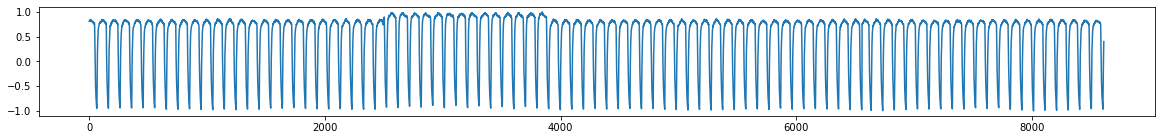

Stage#1: Calculating the first discord...
Discords after finding the first one: 
 [2452, 50, 6513, 6.988589716525622]
Stage#2: Calculating the next four discords...
>>> Discords after finding the next four discords:  [2455, 51, 6516, 7.21034079543704]
>>> Discords after finding the next four discords:  [2454, 52, 6515, 7.3796824145701265]
>>> Discords after finding the next four discords:  [2453, 53, 6514, 7.653534419834977]
>>> Discords after finding the next four discords:  [2452, 54, 6513, 7.864855363689324]
Stage#3: Calculating the remaining discords...
>>> new discord:  [2451, 55, 6512, 8.098133947700275]
>>> new discord:  [2450, 56, 3025, 7.981972696303882]
>>> new discord:  [2449, 57, 8527, 8.063921231460577]
>>> new discord:  [2448, 58, 3023, 7.853800659646501]
>>> new discord:  [2447, 59, 3022, 7.742214310284297]
>>> new discord:  [2446, 60, 8524, 7.646865919342419]
>>> new discord:  [2445, 61, 8523, 7.495948336002726]
>>> new discord:  [2444, 62, 8522, 7.132423463703552]
>>> 

>>> new discord:  [6459, 194, 8218, 13.034678109083059]
>>> new discord:  [6459, 195, 8218, 13.092185101044661]
>>> new discord:  [6458, 196, 8216, 13.183138973382674]
>>> new discord:  [6458, 197, 8216, 13.242060076101428]
>>> new discord:  [6458, 198, 8216, 13.291416221047605]
>>> new discord:  [6458, 199, 8217, 13.329938988865312]
>>> new discord:  [6458, 200, 8217, 13.36279103835696]
>>> new discord:  [6457, 201, 8213, 13.410035736173581]
>>> new discord:  [6457, 202, 8214, 13.450329899173258]
>>> new discord:  [6457, 203, 8215, 13.480367752115198]
>>> new discord:  [6457, 204, 8215, 13.508163751453068]
>>> new discord:  [6457, 205, 8215, 13.535970829715493]
>>> new discord:  [6457, 206, 8215, 13.562534002739897]
>>> new discord:  [6457, 207, 8215, 13.58831923577682]
>>> new discord:  [6457, 208, 8215, 13.613733358880088]
>>> new discord:  [6457, 209, 8215, 13.638538826234344]
>>> new discord:  [6457, 210, 8215, 13.66172002556634]
>>> new discord:  [6457, 211, 8215, 13.685795980662

>>> new discord:  [6415, 341, 2294, 16.861476076173364]
>>> new discord:  [6413, 342, 2292, 16.877204118694255]
>>> new discord:  [6413, 343, 2292, 16.892975803442756]
>>> new discord:  [6413, 344, 2292, 16.90813021312782]
>>> new discord:  [6413, 345, 2292, 16.92368031359006]
>>> new discord:  [6413, 346, 2292, 16.93836060643106]
>>> new discord:  [6411, 347, 2290, 16.953636007986056]
>>> new discord:  [6411, 348, 2290, 16.96834501387713]
>>> new discord:  [6411, 349, 2290, 16.98327047907773]
>>> new discord:  [6411, 350, 2290, 16.99820027418349]
>>> new discord:  [6411, 351, 2290, 17.012675597318633]
>>> new discord:  [6408, 352, 2287, 17.02728837245877]
>>> new discord:  [6405, 353, 2284, 17.04242583890579]
>>> new discord:  [6404, 354, 2283, 17.057768876746664]
>>> new discord:  [6404, 355, 2283, 17.072572227614536]
>>> new discord:  [6402, 356, 2281, 17.087985734138396]
>>> new discord:  [6399, 357, 2278, 17.103199956937875]
>>> new discord:  [6400, 358, 2279, 17.11860253472269]
>

>>> new discord:  [6338, 489, 2213, 19.868673062240656]
>>> new discord:  [6338, 490, 2214, 19.909058797770758]
>>> new discord:  [6337, 491, 2213, 19.953655587109044]
>>> new discord:  [6336, 492, 2211, 19.987828510869488]
>>> new discord:  [6335, 493, 2210, 20.004419255909585]
>>> new discord:  [6335, 494, 2211, 20.02218789813033]
>>> new discord:  [6334, 495, 2210, 20.03865342935066]
>>> new discord:  [6333, 496, 2209, 20.05499717119008]
>>> new discord:  [6332, 497, 2208, 20.071006975682156]
>>> new discord:  [6331, 498, 2207, 20.08690362679942]
>>> new discord:  [6330, 499, 2206, 20.102727027693405]
>>> new discord:  [6329, 500, 2205, 20.11835952568508]
----------------------------
Discords are:  [[2452.0 50.0 6513.0 6.988589716525622]
 [2455.0 51.0 6516.0 7.21034079543704]
 [2454.0 52.0 6515.0 7.3796824145701265]
 ...
 [6331.0 498.0 2207.0 20.08690362679942]
 [6330.0 499.0 2206.0 20.102727027693405]
 [6329.0 500.0 2205.0 20.11835952568508]]
----------------------------


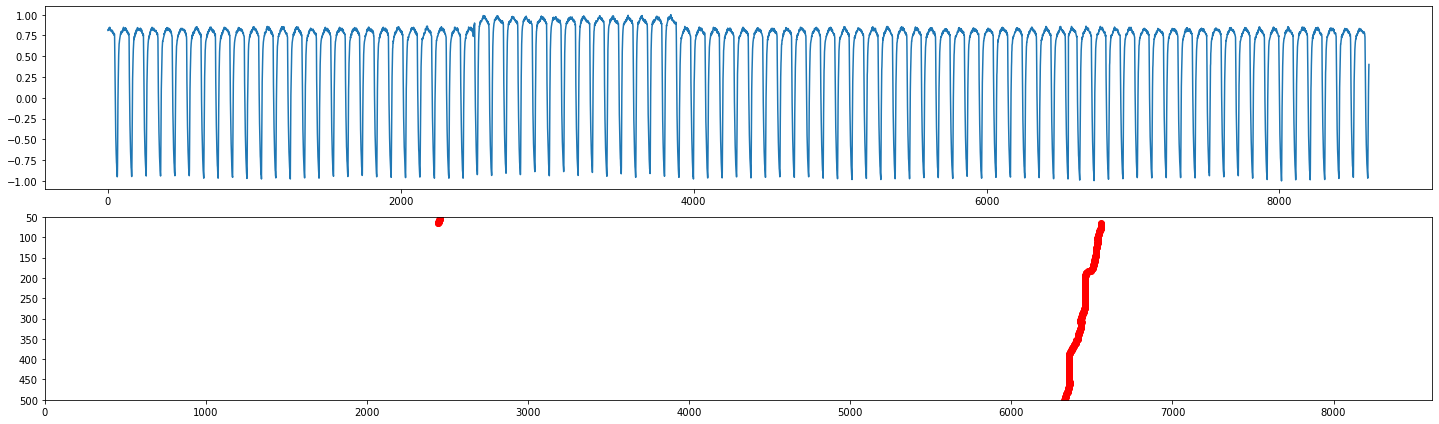

In [50]:
df_MSL_topFigure = pd.read_csv("MERLIN_datasets\\Mars Science Laboratory\\T-1.csv", header=None) 
ts = np.reshape(df_MSL_topFigure.to_numpy(), newshape = (-1, ))

#plot data
plt.figure(figsize=(20,2))
plt.plot(ts)
plt.show()

#finging discords of different length
MinL = 50; MaxL = 500;
Discords = MERLIN(ts, MinL, MaxL)
print('----------------------------')
print('Discords are: ', Discords)
print('----------------------------')


#now, let's plot the discords
n_ts = len(ts)
fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(ts)

ax[1].set_xlim(left=0, right=n_ts-1) 
ax[1].set_ylim(bottom=MaxL, top=MinL) 
for item in Discords:
    ax[1].scatter(x=int(item[0]), y=int(item[1]),c='r')

fig.tight_layout()
plt.show()

# Implementing fastMERLIN (provided in the supporting page of the paper)

In [167]:
import time
import math
import copy

In [168]:
def fastMERLIN(T, minL, maxL, min_dist=None, min_sep_fraction = None, max_block_size=256):
    """
    Input:
    -------
    T: a 1d-array
    minL: discord's minimum length
    maxL: discord's maximum length
    min_dist: minimum "z-normalized euclidean distance" a discord should must have with its nearest neighbor
    If None, it is set to 2*sqrt(minL+1)
    min_sep_fraction: sets the exclusion zone width (from center) as sep = math.ceil(min_sep_fraction*min_sep_fraction). 
    So, the exclusion zone for i-th subsequence becomes [i-sep+1, i + sep -1]. If None, it is set
    to 1/4. It can take any value in (0,1]
    max_block_size: the block size based on which the algorithm find the candidates 
    

    Output:
    -------
    NOTE: num_L = maxL - minL + 1
    
    discord_indices: a 1d array of size num_L that stores the indices of all discovered discords
    discord_NN_indices: a 1d array of size num_L that stores the indices of discovered
    discords's nearest neighbors
    discord_dist: a 1d array of size num_L that stores the distance between each discord and
    its nearest neighbors
    discord_times: a 1d array of size num_L that stores the computation time spent for finding discords in seconds
    discord_misses: a 1d array of size num_L that stores the number of times that we had to reduce min_dist to
    allow algorithm find a discord
    """
    if min_dist is None:
        min_dist = 2 * np.sqrt(minL+1) #changed to minL+1 to consider stumpy's z-normalization
    
    #set min_sep if it is not set by the user
    if min_sep_fraction is None:
        min_sep_fraction = 1/4
    
    L_values = np.arange(minL, maxL+1)
    n_discords = len(L_values) #number of discords that will be discovered

    discord_indices = np.empty(n_discords, dtype='int')
    discord_NN_indices = np.empty(n_discords, dtype='int')
    discord_dists = np.empty(n_discords)

    discord_times = np.zeros(n_discords)
    discord_misses = np.zeros(n_discords, dtype='int')

    for i, L in enumerate(L_values):
        print('---')
        print(f'>>> L: {L}')
        tic = time.time()
        while True:
            print(f'.....ATTEMPT: #{discord_misses[i]}: USING min_dist: {min_dist}.....')
            tmp_discord_idx, tmp_discord_nn_idx, tmp_discord_dist = fastMerlin_helper(T, L, min_dist, min_sep_fraction, max_block_size)
            if len(tmp_discord_idx):
                break
            min_dist = min_dist * (L-1) / L #use smaller L
            discord_misses[i] += 1
        
        top_loc = np.argmax(tmp_discord_dist)

        discord_indices[i] = tmp_discord_idx[top_loc]
        discord_NN_indices[i] = tmp_discord_nn_idx[top_loc]
        discord_dists[i] = tmp_discord_dist[top_loc]

        min_dist = discord_dists[i]
        toc = time.time()
        discord_times[i] = toc - tic
        print(f'CASE L={L}: computation time: {discord_times[i]} sec')
        
    return discord_indices, discord_NN_indices, discord_dists, discord_times, discord_misses


In [169]:
def fastMerlin_helper(T, L, min_dist, min_sep_fraction=None, max_block_size=256):
    """
    This function finds all discords of length L in time series T 
    and the discovered discords have minimum distance of min_dist to their nearest neighbor. 
    
    Input
    -----
    T: 1d-array time series
    L: length of discord
    min_dist: a minimum z-normalized euclidean distance that a discord must have with its nearest neighbor.
    min_sep_fraction: make the exclusion zone width (from center) as sep = math.ceil(min_sep_fraction*min_sep_fraction). 
    So, the exclusion zone for i-th subsequence becomes [i-sep+1, i + sep -1]
    max_block_size: the block size based on which the algorithm find the candidates 
    

    Output
    ------
    discord_idx: 1d-array that contains the indices of discovered candidates for discord of size L
    discord_nn_idx: 1d-array that contains the NN's indices of discovered candidates for discord of size L
    discord_dist: 1d-array that contains the distance between each candidate and its NN
    """
    #Check if inputs are correct
    if not (0 < min_dist <= 2 * np.sqrt(L+1)): #upper bound changed to 2*sqrt(L+1) to consider stumpy z-normalization
        raise ValueError("A valid choice of min_dist must be greater than 0 and less than or equal to 2*sqrt(L)")
        
    if not (4 <= L <= len(T)//2):
        raise ValueError("the  length of L must be in the range of 4 <= L <= floor(len(T)/2)")
    
    
    min_sep = math.ceil(L * min_sep_fraction)
    min_sep = min_sep + 1
    
    #calculate total number of subsequences with length L in T
    n = len(T) - L + 1
    
    #transforms min_dist into a correlation coefficient:
    r = (1 - (min_dist ** 2) / (2 * L)) * L # the outter *L is added because of using stumpy z-normalization 
    
    #transform all subsequences and keep them
    subsequences = np.zeros((n, L))
    for i in range(n):
        subsequences[i, :] = T[i: i+L]
    subsequences = stumpy.core.z_norm(subsequences, axis=1)
        
    if max_block_size is None:
        max_block_size = 256 #this is to check the data chunk by chunk
    num_block = math.ceil(len(T)/max_block_size)
    
    cand = np.zeros((n, L)) #to store candidates (filling from index 0)
    cand_index = np.zeros(n, dtype='int') # to store index that shows beginning of candidates (filling from index 0)
    counter = 0 #counter of discovered discords so far
    
    ###################################################
    ############## > phase I < ########################
    #In this phase we compare  the subsequences of a block with all discords found in previous blocks.
    #Also, we do within-block comparison to reject some of subsequences 
    
    print('#phase I: start!')
    for itr, i in enumerate(range(0, n, max_block_size)):
        print(f'{itr}-th block out of {num_block}')
        
        block_len = min(max_block_size, n - i) #to consider n % max_block_size != 0
        is_cand_in_block = np.full(block_len, True)
        
        #there are already some discords discovered from previous blocks
        
        if counter > 0: 
            is_cand_so_far = np.full(counter, True)
            if cand_index[:counter][0] <= i + block_len - min_sep - 1: #NOTE: this condition always true?
                last_cmp = np.where(cand_index[:counter] <= i + block_len - min_sep -1)[0][-1]
                
                if cand_index[:counter][0] > i - min_sep:
                    last_no_conflict = -1
                else:
                    last_no_conflict = np.where(cand_index[:counter][0] <= i - min_sep)[0][-1]
                
                    corr = np.matmul(cand[:(last_no_conflict+1), :], subsequences[i : (i + block_len), :].T)
                    mask = (corr > r) 
                    is_cand_in_block[np.any(mask, axis=0)] = False
                    is_cand_so_far[np.ix_(np.any(mask, axis=1))[0]] = False
                
                #we already checked discords upto last_no_conflict (inclusive),
                #now, we should compare the rest till last_cmp
                for pos in range(last_no_conflict+1, last_cmp+1):
                    first_cmp = max(i, cand_index[pos] + min_sep) #NOTE: this condition always true?
                    corr = np.matmul(cand[pos,:], subsequences[first_cmp: i+block_len, :].T)
                    eject_loc = np.where(corr > r)[0] + first_cmp - i
                    if eject_loc.size:
                        is_cand_so_far[pos] = False
                        is_cand_in_block[eject_loc] = False
                
                
                surviving_counter = np.sum(is_cand_so_far)
                if surviving_counter < counter: #if can be removed, but we may lose speed
                    counter = surviving_counter
                    tmp_loc = np.where(is_cand_so_far)[0]
                    cand_index[:counter] = cand_index[tmp_loc]
                    cand[:counter, :] = cand[tmp_loc, :]
                
    
        #within block comparison
        if block_len > min_sep:
            for pos in range(min_sep, block_len):
                corr = np.matmul(subsequences[i+pos,:], subsequences[i:i+pos-min_sep+1 ,:].T)
                mask = (corr > r)
                if np.sum(mask)>0:
                    is_cand_in_block[pos] = False
                    is_cand_in_block[np.where(mask)[0]] = False

    
        #update:
        cand_actual_idx = np.where(is_cand_in_block)[0] + i
        if len(cand_actual_idx)>0:
            prev_counter = counter
            counter = counter + len(cand_actual_idx)
            cand[prev_counter:counter,:] = subsequences[cand_actual_idx]
            cand_index[prev_counter:counter] = cand_actual_idx

    #############################################
    ############# >> phase II << ################
    #now, we compare the sequences of a blcok with all discords candidate
    #that located later in the time series
    
    print('#pahse II: start!')
    for itr, i in enumerate(range(0, n, max_block_size)):
        print(f'{itr}-th block out of {num_block}')
            
        if counter == 0:
            break
        
        is_cand_so_far = np.full(counter, True)
        block_len = min(max_block_size, n - i)
        
        min_index = max(i + block_len, i + min_sep)
        
        if cand_index[:counter][-1] < min_index:
            break #because there is no discord left after this block
        
        first_cmp = np.where(cand_index[:counter] >= min_index)[0][0]
        no_conflict_begin = i + block_len + min_sep
        
        if cand_index[:counter][-1] < no_conflict_begin:  #i.e. all discords aftet this block has a conflict
            first_no_conflict = counter #?
        else:
            first_no_conflict = np.where(cand_index[first_cmp:counter] >= no_conflict_begin)[0][0] + first_cmp
        
        for pos in range(first_cmp, first_no_conflict):
            corr = np.matmul(cand[pos,:], subsequences[i : cand_index[pos] - min_sep + 1, :].T)
            if np.any(corr > r):
                is_cand_so_far[pos] = False
        
        if first_no_conflict < counter:
            corr = np.matmul(cand[first_no_conflict:counter, :], subsequences[i:i+block_len ,:].T)
            mask = (corr > r)
            ejoct_loc = np.where(np.any(mask, axis=1))[0] + first_no_conflict
            is_cand_so_far[ejoct_loc] = False
        
        #update:
        surviving_counter = np.sum(is_cand_so_far)
        if  surviving_counter < counter:
            counter = surviving_counter
            tmp_loc = np.where(is_cand_so_far)[0]
            cand_index[:counter] = cand_index[tmp_loc]
            cand[:counter, :] = cand[tmp_loc, :]
        
    
    ################################################
    ############# >>> Phase III <<< ################
    #so far, we only discover the candidates, i.e. their distance to their NN 
    # bigger than min_dist

    #now, we try to find the NN of  the candidates in this phase
    
    
    #inilizing output
    discord_idx = cand_index[:counter] #not going to be changed!
    discord_nn_idx = -1 * np.ones(counter, dtype='int')
    discord_dist = -1 * np.ones(counter)
    
    cand = cand[:counter,:]
    cand_index = cand_index[:counter]
    
    print('#phase III: start!')
    if counter > 0:
        for itr, i in enumerate(range(0, n, max_block_size)):
            print(f'{itr}-th block out of {num_block}')
            block_len = min(max_block_size, n - i)
            
            #to see what discords can have conflict with the subsequences of block
            #NOTE: please note that the subsequences of block mean all the subseqeunces whose 
            #starting index is in the block!
            mask = (cand_index > i - min_sep) & (cand_index < i + block_len + min_sep -1) 
            
            with_conflicts = np.where(mask)[0]
            if not len(with_conflicts):
                first_conflict = counter
                last_conflict = []
            else:
                first_conflict = with_conflicts[0]
                last_conflict = with_conflicts[-1]
        
            if first_conflict >= 1:
                #so there are some discords (before first_conflict) that don't have conflict with block
                corr = np.matmul(cand[:first_conflict,:], subsequences[i:i+block_len,:].T)
                max_corr_idx = np.argmax(corr, axis=1)
                max_corr = corr[np.arange(corr.shape[0]), max_corr_idx]

                update = np.where(max_corr > discord_dist[:first_conflict])[0]
                discord_nn_idx[update] = max_corr_idx[update] + i
                discord_dist[update] = max_corr[update]
    
    
            if first_conflict < counter:
                #now, let's consider those discordss that have conflicts with current block
                for pos in range(first_conflict, last_conflict + 1):
                    #conflicting with ONLy the beginning of the block 
                    
                    if abs(cand_index[pos] - i) < min_sep:
                        if abs(cand_index[pos] - (i+block_len-1) ) >= min_sep : 
                            cmp_begin = cand_index[pos] + min_sep



                            corr = np.matmul(cand[pos,:], subsequences[cmp_begin : i + block_len, :].T)
                            max_corr_idx = np.argmax(corr)
                            max_corr = corr[max_corr_idx]
                            if max_corr > discord_dist[pos]:
                                discord_nn_idx[pos] = max_corr_idx + cmp_begin
                                discord_dist[pos] = max_corr

                    #conflicting with the end of the block 
                    elif abs(cand_index[pos] - (i+block_len-1) ) < min_sep:
                        corr = np.matmul(cand[pos,:], subsequences[i : (cand_index[pos] - min_sep + 1), :].T) # + 1?
                        max_corr_idx = np.argmax(corr)
                        max_corr = corr[max_corr_idx]
                        if max_corr > discord_dist[pos]:
                            discord_nn_idx[pos] = max_corr_idx + i
                            discord_dist[pos] = max_corr

                    #no conflict with the two ends of block (it is inside the block!)
                    else:
                        corr_left = np.matmul(cand[pos,:], subsequences[i : (cand_index[pos] - min_sep + 1), :].T)
                        corr_right = np.matmul(cand[pos,:], subsequences[(cand_index[pos] + min_sep) : i+block_len, :].T)
                        
                        max_corr_left_idx = np.argmax(corr_left)
                        max_corr_right_idx = np.argmax(corr_right)
                        
                        max_corr_left = corr_left[max_corr_left_idx]
                        max_corr_right = corr_right[max_corr_right_idx]
                        
                        if max_corr_left > max_corr_right:
                            max_corr = max_corr_left
                            max_corr_idx = max_corr_left_idx + i
                        else:
                            max_corr = max_corr_right
                            max_corr_idx = max_corr_right_idx + cand_index[pos] + min_sep

                        if max_corr > discord_dist[pos]:
                            discord_nn_idx[pos] = max_corr_idx
                            discord_dist[pos] = max_corr
                    
                    
                    
                if last_conflict < counter-1:
                    #i.e. there some discords after the block that
                    #do not have conflict with it
                    corr = np.matmul(cand[last_conflict+1:, :], subsequences[i: i+block_len].T)
                    max_corr_idx = np.argmax(corr, axis=1)
                    max_corr = corr[np.arange(corr.shape[0]), max_corr_idx]

                    update = np.where(max_corr > discord_dist[last_conflict+1:])[0]
                    discord_nn_idx[update+last_conflict+1] = max_corr_idx[update] + i
                    discord_dist[update+last_conflict+1] = max_corr[update]        

    print('end of three-phase process!')
    
    tmp = 2*L*(1-discord_dist/L)
    discord_dist = np.sqrt(np.where(tmp>0, tmp, 0))

    return discord_idx, discord_nn_idx, discord_dist

# Let's use fastMERLIN on TAXI data (Fig. 11)

we already applied MERLIN on TAXI data. Now, we would like to see the result by using fastMERLIN

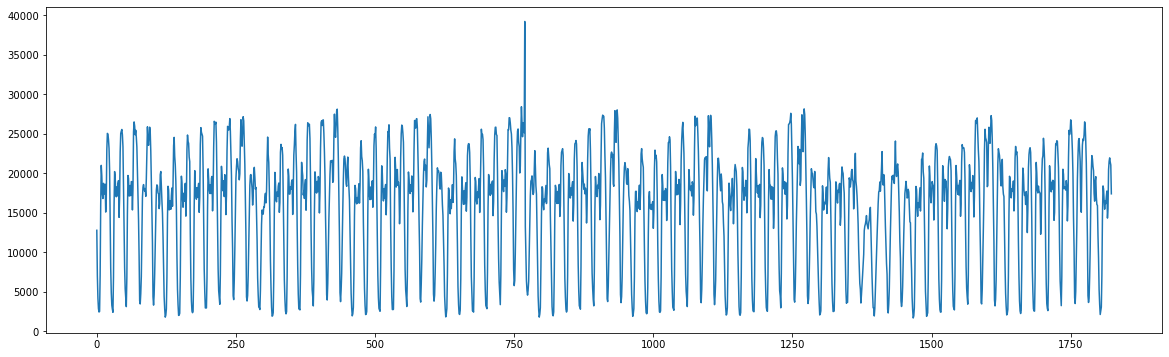

In [170]:
#read data
df_taxi = pd.read_csv("MERLIN_datasets\\NAB_NYC_TAXI\\data\\realKnownCause\\nyc_taxi.csv") 
df_taxi = df_taxi.set_index(['timestamp'])

#select the range of dates considered in the paper
data =  df_taxi.loc['2014-10-01 00:00:00' : '2014-12-15 23:00:00']

ts = np.reshape(data.to_numpy(),newshape=(-1,))
#let's consider only the data at each hour (not the half hours)
ts = [val for i,val in enumerate(ts) if i % 2 == 0]
ts = np.asarray(ts)

#to use it later in  MATLAB 
np.savetxt("taxi_to_reproduce_paper.csv", ts, delimiter=",")

#plottting
plt.plot(ts)
plt.show()

In [171]:
#apply fastMERLIN
(discord_indices, 
 discord_NN_indices, 
 discord_dists, 
 discord_times, 
 discord_misses) = fastMERLIN(ts, 
                               5, 96,
                               min_dist=None
                             )


discord_indices_fastMERLIN = discord_indices
discord_NN_indices_fastMERLIN =  discord_NN_indices
discord_dists_fastMERLIN = discord_dists
time_fastMERLIN = discord_times

print('fastMERLIN takes: ', sum(time_fastMERLIN))

---
>>> L: 5
.....ATTEMPT: #0: USING min_dist: 4.898979485566356.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
7-th block out of 8
#pahse II: start!
0-th block out of 8
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 3.919183588453085.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
7-th block out of 8
#pahse II: start!
0-th block out of 8
#phase III: start!
end of three-phase process!
.....ATTEMPT: #2: USING min_dist: 3.1353468707624677.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
7-th block out of 8
#pahse II: start!
0-th block out of 8
#phase III: start!
end of three-phase process!
.....ATTEMPT: #3: USING min_d

1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
7-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
#phase III: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
7-th block out of 8
end of three-phase process!
CASE L=15: computation time: 0.038901567459106445 sec
---
>>> L: 16
.....ATTEMPT: #0: USING min_dist: 3.726216368849502.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
7-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
#phase III: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
7-th block out of 8
end of three-pha

6-th block out of 8
7-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
#phase III: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
7-th block out of 8
end of three-phase process!
CASE L=23: computation time: 0.04488062858581543 sec
---
>>> L: 24
.....ATTEMPT: #0: USING min_dist: 2.5667423636833826.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
7-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
#phase III: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
7-th block out of 8
end of three-phase process!
CASE L=24: computation time: 0.04288434982299805

1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
#phase III: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
end of three-phase process!
CASE L=39: computation time: 0.05385446548461914 sec
---
>>> L: 40
.....ATTEMPT: #0: USING min_dist: 4.104426087834105.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
#phase III: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of

#pahse II: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
#phase III: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
end of three-phase process!
CASE L=52: computation time: 0.0957491397857666 sec
---
>>> L: 53
.....ATTEMPT: #0: USING min_dist: 4.290034033714778.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
#phase III: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
end of three-phase process!
CASE L=53: computation time: 0.04487872123718262 sec
---
>>> L: 54
...

5-th block out of 8
#phase III: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
end of three-phase process!
CASE L=69: computation time: 0.03390955924987793 sec
---
>>> L: 70
.....ATTEMPT: #0: USING min_dist: 5.516037055610618.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 5.437236526244752.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out 

1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
#phase III: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
end of three-phase process!
CASE L=82: computation time: 0.03989410400390625 sec
---
>>> L: 83
.....ATTEMPT: #0: USING min_dist: 5.921207098595222.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
#phase III: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of

4-th block out of 8
5-th block out of 8
6-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
#phase III: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
end of three-phase process!
CASE L=94: computation time: 0.09574127197265625 sec
---
>>> L: 95
.....ATTEMPT: #0: USING min_dist: 6.309159708057134.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 6.242747500603902.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
#pahse II: star

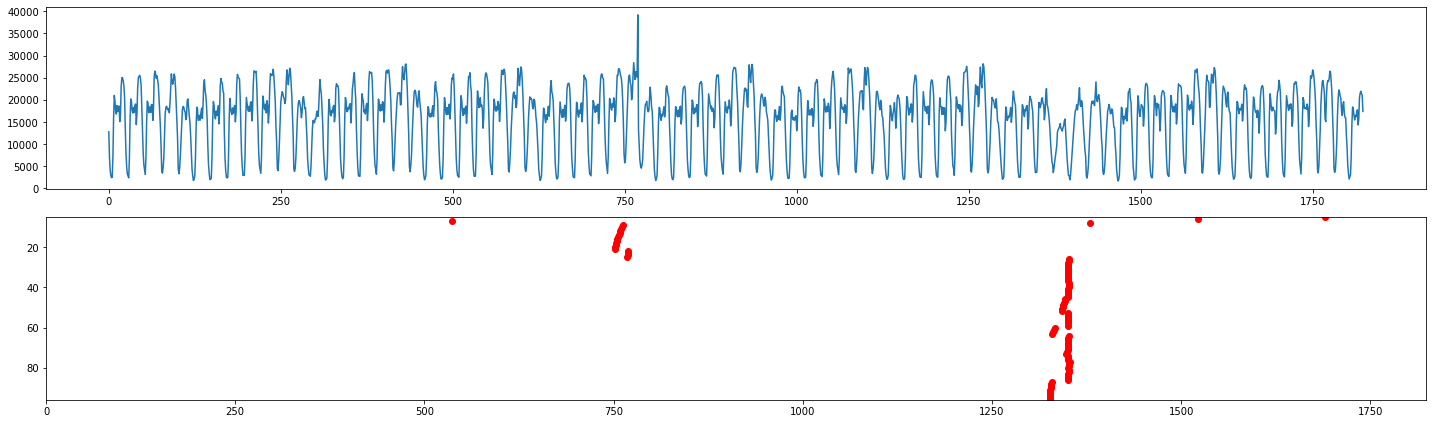

time_fastMERLIN:  5.498332262039185


In [172]:
#plot discords indices and their corresponding length
n_ts = len(ts)

fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(ts)

ax[1].set_xlim(left=0, right=n_ts-1) 
ax[1].set_ylim(bottom=96, top=5) 
for i, L in enumerate(np.arange(5,97)):
    ax[1].scatter(x=discord_indices[i], y=L, c='r')

fig.tight_layout()
plt.show()

print('time_fastMERLIN: ', sum(time_fastMERLIN))

To make sure the results of MERLIN and fastMERLIN are the same, we apply MERLIN below and compare its result 
with what achieved by fastMERLIN

In [173]:
tic = time.time()
Discords = MERLIN(ts, 5, 96, separation_fraction=None) #separation_fraction=None: means stumpy default setting for ignoring trivial checks
toc = time.time()

#computation time:
time_MERLIN = toc - tic

Stage#1: Calculating the first discord...
Discords after finding the first one: 
 [1690, 5, 1120, 1.3642079150627304]
Stage#2: Calculating the next four discords...
>>> Discords after finding the next four discords:  [1522, 6, 1100, 1.4064712539239808]
>>> Discords after finding the next four discords:  [537, 7, 1689, 1.62928107746437]
>>> Discords after finding the next four discords:  [1380, 8, 443, 1.746810126819628]
>>> Discords after finding the next four discords:  [762, 9, 1328, 2.0634858945465493]
Stage#3: Calculating the remaining discords...
>>> new discord:  [761, 10, 1327, 2.1247537919540944]
>>> new discord:  [760, 11, 1381, 2.629462897528745]
>>> new discord:  [759, 12, 1380, 2.746225055671875]
>>> new discord:  [758, 13, 1379, 2.9819137944892202]
>>> new discord:  [757, 14, 1261, 3.5977491081910626]
>>> new discord:  [756, 15, 1260, 3.7262163688495025]
>>> new discord:  [755, 16, 1259, 3.8542112273477858]
>>> new discord:  [754, 17, 1258, 3.773480491623614]
>>> new disco

In [175]:
discord_indices_MERLIN = np.array([int(x) for x in Discords[:,0]])
discord_NN_indices_MERLIN =  np.array([int(x) for x in Discords[:,1]])
discord_dists_MERLIN = Discords[:,3]

print('computation time when using MERLIN: ', time_MERLIN) 

computation time when using MERLIN:  394.65088534355164


please note that we are z-normalizing each subseq in each iteration. creating the all_subsequnces matrix and having the z-normalized subsequences ready might reduce the computation time. Therefore, to compare MERLIN and fastMERLIN regarding their computation time, we used the MATLAB code!

## Using Matrix Profile to get discords

In [176]:
ts = ts.astype(np.float64)

#let's use matrix profile
n_discords = 96 - 5 + 1

discord_indices_MP = np.zeros(n_discords, dtype='int')
discord_NN_indices_MP = np.zeros(n_discords, dtype='int')
discord_dists_MP = np.zeros(n_discords)
time_MP = np.zeros(n_discords)

for i, L in enumerate(np.arange(5,97)):
    print(f'L={L}', end='>>>')
    tic = time.time()
    
    mp = stumpy.stump(ts, L, ignore_trivial=True, normalize=True)
    idx = np.argmax(mp[:,0])
    
    discord_indices_MP[i] = idx
    discord_NN_indices_MP[i] = mp[idx,1]
    discord_dists_MP[i] = mp[idx,0]
    
    toc = time.time()
    time_MP[i] = toc - tic

L=5>>>L=6>>>L=7>>>L=8>>>L=9>>>L=10>>>L=11>>>L=12>>>L=13>>>L=14>>>L=15>>>L=16>>>L=17>>>L=18>>>L=19>>>L=20>>>L=21>>>L=22>>>L=23>>>L=24>>>L=25>>>L=26>>>L=27>>>L=28>>>L=29>>>L=30>>>L=31>>>L=32>>>L=33>>>L=34>>>L=35>>>L=36>>>L=37>>>L=38>>>L=39>>>L=40>>>L=41>>>L=42>>>L=43>>>L=44>>>L=45>>>L=46>>>L=47>>>L=48>>>L=49>>>L=50>>>L=51>>>L=52>>>L=53>>>L=54>>>L=55>>>L=56>>>L=57>>>L=58>>>L=59>>>L=60>>>L=61>>>L=62>>>L=63>>>L=64>>>L=65>>>L=66>>>L=67>>>L=68>>>L=69>>>L=70>>>L=71>>>L=72>>>L=73>>>L=74>>>L=75>>>L=76>>>L=77>>>L=78>>>L=79>>>L=80>>>L=81>>>L=82>>>L=83>>>L=84>>>L=85>>>L=86>>>L=87>>>L=88>>>L=89>>>L=90>>>L=91>>>L=92>>>L=93>>>L=94>>>L=95>>>L=96>>>

### NOW, let's compare fastMERLIN vs MP (and vs MERLIN):

Here, we try to substract the arrays that contain the corresponding info for discords of length 5-96 (i.e. length of array: 92)

In [177]:
#To compare indices of discords

print('>>> diff between discord indices discovered by fastMERLIN and MP: \n', discord_indices_fastMERLIN - discord_indices_MP)
print('---------------------------------------------')
print('>>> diff between discord indices discovered by MERLIN and MP: \n', discord_indices_MERLIN - discord_indices_MP)


>>> diff between discord indices discovered by fastMERLIN and MP: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
---------------------------------------------
>>> diff between discord indices discovered by MERLIN and MP: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [178]:
#to check it with MERLIN MATLAB:
MERLIN_bug_idx = np.where(discord_indices_MERLIN - discord_indices_MP > 0)[0]
print('potential bug of MERLIN located at index (of output array): ', MERLIN_bug_idx)
print('indices discovered by Python MERLIN are: ', discord_indices_MERLIN[MERLIN_bug_idx])

potential bug of MERLIN located at index (of output array):  []
indices discovered by Python MERLIN are:  []


**NOTE:** After checking out the output of MATLAB MERLIN for the above cases, it seems the MATLAB MERLIN is not correct as the results are not similar to what achieved by STUMpy MatrixProfile. We can see a similar problem in differences in the dist-to-NN shown below

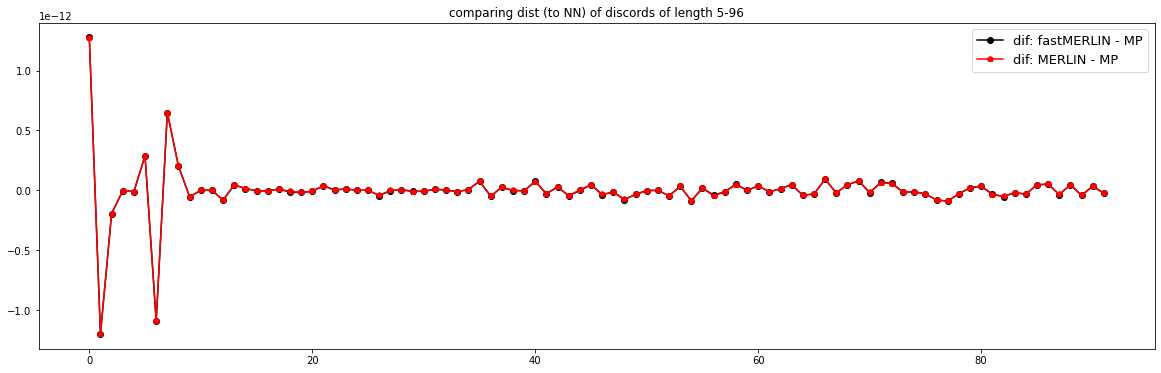

In [179]:
#To compare dist of discords to their NN, we plot the difference between fastMERLIN/MERLIN and MP 
plt.figure()
plt.title('comparing dist (to NN) of discords of length 5-96')

plt.plot(discord_dists_fastMERLIN - discord_dists_MP, c='k', marker='o', label='dif: fastMERLIN - MP')
plt.plot(discord_dists_MERLIN - discord_dists_MP, c='r', marker='p', label='dif: MERLIN - MP')

plt.legend(loc=1, fontsize=13)
plt.show()

In [181]:
#To compare NN indices of discords

print('>>> diff between discord NN indices discovered by fastMERLIN and MP: \n', discord_NN_indices_fastMERLIN - discord_NN_indices_MP)
print('---------------------------------------------')
print('>>> diff between discord NN indices discovered by MERLIN and MP: \n', discord_NN_indices_MERLIN - discord_NN_indices_MP)


>>> diff between discord NN indices discovered by fastMERLIN and MP: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
---------------------------------------------
>>> diff between discord NN indices discovered by MERLIN and MP: 
 [-1115 -1094 -1682  -435 -1319 -1317 -1370 -1368 -1366 -1247 -1245 -1243
 -1241 -1239 -1574 -1572 -1571   -75   -74   -73   -71 -1375 -1374 -1372
  -220  -219  -218  -217  -216  -215  -214  -213  -212  -212  -210  -209
  -207  -206  -204  -203  -202  -199  -197  -195  -193  -192  -190  -188
  -195  -194  -193  -192  -191  -190  -189  -171  -169  -167  -164  -903
  -901  -900  -899  -898  -897  -895  -894  -892  -890 -1228 -1226 -1226
  -891    70    71    73 -1439 -1438 -1436 -1435 -1433 -1432  -858 -1072
 -1407 -1406 -1404 -1547 -1546  -537 -1543 -1542]


**NOTE:** fastMERLIN preserves the order of subsequences. Therefore, it is possible to have more than 1 NN. However, MERLIN cannot preserve the order of subsequences as they appear in T. Therefore, we might end up with different NN when we use MERLIN.

## Let's compare fastMERLIN and MP for another data set (used in the paper)

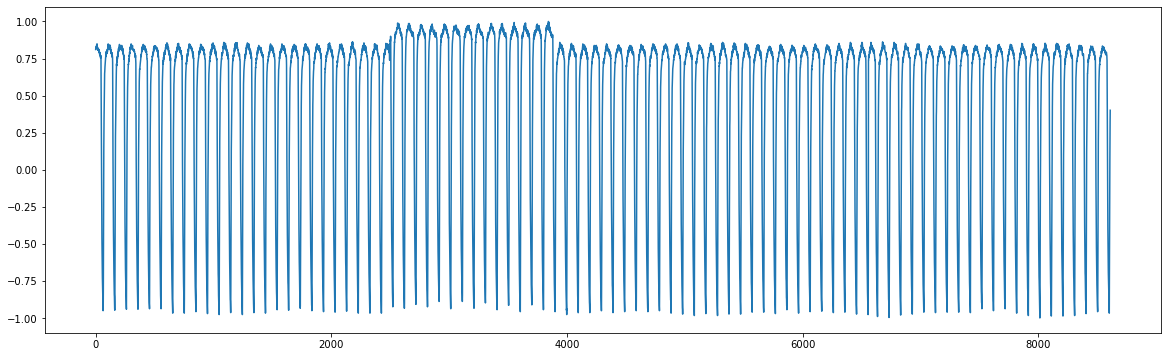

with length:  8612


In [182]:
df_MSL_topFigure = pd.read_csv("MERLIN_datasets\\Mars Science Laboratory\\T-1.csv", header=None)
ts = np.reshape(df_MSL_topFigure.to_numpy(), newshape = (-1, ))
ts = ts.astype(np.float64)

plt.plot(ts)
plt.show()
print('with length: ', len(ts))

In [183]:
#setting  the lower bound and upper bound for the length of discords
minL = 50; maxL = 500;
L_vec =  np.arange(minL,maxL+1)

In [184]:
#use MP:
n_discords = maxL - minL + 1

discord_indices_MP = np.zeros(n_discords, dtype='int')
discord_NN_indices_MP = np.zeros(n_discords, dtype='int')
discord_dists_MP = np.zeros(n_discords)
time_MP = np.zeros(n_discords)

for i, L in enumerate(np.arange(minL,maxL+1)):
    print(f'L={L}', end='>>>')
    tic = time.time()
    
    mp = stumpy.stump(ts, L, ignore_trivial=True, normalize=True)
    idx = np.argmax(mp[:,0])
    
    discord_indices_MP[i] = idx
    discord_NN_indices_MP[i] = mp[idx,1]
    discord_dists_MP[i] = mp[idx,0]
    
    toc = time.time()
    time_MP[i] = toc - tic

L=50>>>L=51>>>L=52>>>L=53>>>L=54>>>L=55>>>L=56>>>L=57>>>L=58>>>L=59>>>L=60>>>L=61>>>L=62>>>L=63>>>L=64>>>L=65>>>L=66>>>L=67>>>L=68>>>L=69>>>L=70>>>L=71>>>L=72>>>L=73>>>L=74>>>L=75>>>L=76>>>L=77>>>L=78>>>L=79>>>L=80>>>L=81>>>L=82>>>L=83>>>L=84>>>L=85>>>L=86>>>L=87>>>L=88>>>L=89>>>L=90>>>L=91>>>L=92>>>L=93>>>L=94>>>L=95>>>L=96>>>L=97>>>L=98>>>L=99>>>L=100>>>L=101>>>L=102>>>L=103>>>L=104>>>L=105>>>L=106>>>L=107>>>L=108>>>L=109>>>L=110>>>L=111>>>L=112>>>L=113>>>L=114>>>L=115>>>L=116>>>L=117>>>L=118>>>L=119>>>L=120>>>L=121>>>L=122>>>L=123>>>L=124>>>L=125>>>L=126>>>L=127>>>L=128>>>L=129>>>L=130>>>L=131>>>L=132>>>L=133>>>L=134>>>L=135>>>L=136>>>L=137>>>L=138>>>L=139>>>L=140>>>L=141>>>L=142>>>L=143>>>L=144>>>L=145>>>L=146>>>L=147>>>L=148>>>L=149>>>L=150>>>L=151>>>L=152>>>L=153>>>L=154>>>L=155>>>L=156>>>L=157>>>L=158>>>L=159>>>L=160>>>L=161>>>L=162>>>L=163>>>L=164>>>L=165>>>L=166>>>L=167>>>L=168>>>L=169>>>L=170>>>L=171>>>L=172>>>L=173>>>L=174>>>L=175>>>L=176>>>L=177>>>L=178>>>L=179>>>L=180>>>L=

In [185]:
#use fastMERLIN:
(discord_indices, 
 discord_NN_indices, 
 discord_dists, 
 discord_times, 
 discord_misses) = fastMERLIN(ts, 
                               minL, maxL,
                               min_dist=None
                             )


discord_indices_fastMERLIN = discord_indices
discord_NN_indices_fastMERLIN =  discord_NN_indices
discord_dists_fastMERLIN = discord_dists
time_fastMERLIN = discord_times

print('fastMERLIN takes: ', sum(time_fastMERLIN))

---
>>> L: 50
.....ATTEMPT: #0: USING min_dist: 14.2828568570857.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 13.997199719943987.....
#phase I: start!
0-th block out

25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #10: USING min_dist: 11.670133942592058.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block 

32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #19: USING min_dist: 9.729948058395234.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 

29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #28: USING min_dist: 8.11232241932962.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out

6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out 

22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 7.953524412919914.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out

28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 7.720685394228765.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out

.....ATTEMPT: #1: USING min_dist: 7.375045943486553.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #2: USING min_dist: 7.256093589559351.....
#phase I: start!
0-th bl

31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #4: USING min_dist: 6.690239732959883.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: star

31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #2: USING min_dist: 6.330666602317091.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 

7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 6.1083386709022784.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out o

.....ATTEMPT: #3: USING min_dist: 5.71133538513013.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-t

33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #5: USING min_dist: 5.26686083558543.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26

24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #2: USING min_dist: 5.79477105797728.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19

22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 5.9233083475631085.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block ou

20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 6.00109815630689.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out 

26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out o

23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block o

30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out

10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21

26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out

19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th blo

19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th blo

29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out

21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block

#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out

23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block o

25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out

24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block ou

19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th blo

10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out o

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out o

18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th bl

17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th b

26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out

26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out

7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th

26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out

1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out o

2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th bloc

22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block o

22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block o

22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block o

13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25

23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
end of three-phase process!
CASE L=206: computation time: 0.21043610572814941 sec
---
>>> L: 207
.....ATTEMPT: #0: USING min_dist: 13.411545177007953.....
#phase I: start!
0-th block out of 34
1-th b

26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out

22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block o

8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-t

13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25

26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out

24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out

14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#p

24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out

12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24

19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th bloc

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out o

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out o

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out o

16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th b

19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 14.795921727165673.....
#phase 

31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 14.693918076296512.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 3

32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 14.48878326657429.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34


#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 14.31665693421397.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase proce

5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th 

32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #2: USING min_dist: 13.91609497846969.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34


9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 13.744103653744158.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out

22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block o

25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out o

3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th blo

23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block ou

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out o

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out o

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out o

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out o

11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23

21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block 

10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out o

15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th b

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out o

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out o

21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block o

25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out

#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out

25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out

21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block o

22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 15.063666392305676.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block ou

25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #2: USING min_dist: 14.921308404180127.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block ou

#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 14.584962942277535.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4

#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out

#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #3: USING min_dist: 14.222952425144673.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34


#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #2: USING min_dist: 14.073746331016222.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34


25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out

14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th 

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out o

7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th

12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out o

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out o

4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th bl

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out o

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out o

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out o

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out o

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out o

1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block

15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th bl

12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#p

19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block 

#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out

1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th bloc

30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out

28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out

16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th blo

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: 

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out o

1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th bloc

16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 19.44699708335296.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
1

18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block

1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 19.292072055289115.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out o

31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out o

17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th bloc

CASE L=496: computation time: 0.28324270248413086 sec
---
>>> L: 497
.....ATTEMPT: #0: USING min_dist: 19.70886795269523.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 3

18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
end of three-phase process!
CASE L=500: computation time: 0.30219078063964844 sec
fastMERLIN takes:  136.49895095825195


total diff in indices of discords: 
 0
-------------------------
total diff in NN indices of discords: 
 0
-------------------------
diff in indices of dist-to-NN: see the figure below!


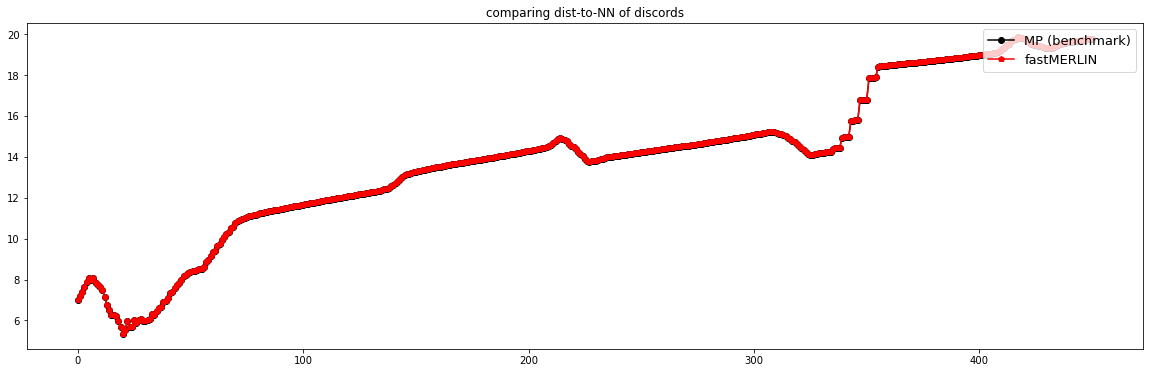

-------------------------
fastMERLIN computation time:  136.49895095825195
MP computation time:  54.776575565338135


In [186]:
print('total diff in indices of discords: \n', np.sum(abs(discord_indices_fastMERLIN - discord_indices_MP)) )
print('-------------------------')
print('total diff in NN indices of discords: \n', np.sum(abs(discord_NN_indices_fastMERLIN - discord_NN_indices_MP)) )
print('-------------------------')

print('diff in indices of dist-to-NN: see the figure below!')
plt.figure()
plt.title('comparing dist-to-NN of discords')

plt.plot(discord_dists_MP, c='k', marker='o', label='MP (benchmark)')
plt.plot(discord_dists_fastMERLIN, c='r', marker='p', label='fastMERLIN')

plt.legend(loc=1, fontsize=13)
plt.show()
      
print('-------------------------')
print('fastMERLIN computation time: ', np.sum(time_fastMERLIN))
print('MP computation time: ', np.sum(time_MP))

In [187]:
#to debug fastMERLIN:
bugs_loc = np.where(discord_indices_fastMERLIN - discord_indices_MP != 0)[0]

bugs_dict = {}

bugs_dict['loc'] =  bugs_loc
bugs_dict['length'] = L_vec[bugs_loc]

bugs_dict['indices by fastMERLIN'] = discord_indices_fastMERLIN[bugs_loc]
bugs_dict['NN indices by fastMERLIN'] = discord_NN_indices_fastMERLIN[bugs_loc]
bugs_dict['dist by fastMERLIN'] = discord_dists_fastMERLIN[bugs_loc]

bugs_dict['indices by MP'] = discord_indices_MP[bugs_loc]
bugs_dict['NN indices by MP'] = discord_NN_indices_MP[bugs_loc]
bugs_dict['dist by MP'] = discord_dists_MP[bugs_loc]

df = pd.DataFrame(bugs_dict)
df #if empty, that means there is no problem

,loc,length,indices by fastMERLIN,NN indices by fastMERLIN,dist by fastMERLIN,indices by MP,NN indices by MP,dist by MP


## Compare fastMERLIN and STUMPY for long time series (Part-1)